In [71]:
from skimage.feature import peak_local_max
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial

from math import sqrt
from skimage import data
from skimage.feature import blob_log
from skimage.color import rgb2gray

In [137]:
def get_LoG_kernel(sigma, normalise = False):
    # We know, r = sigma * sqrt(2)
    # So diameter, d = 2 * sqrt(2) * sigma
    # Define size of kernel
    k_size = int(np.ceil(6 * sigma))

    # If get an even size of kernel, add 1
    if(k_size % 2 == 0):
        k_size = k_size + 1
        

    kernel = np.zeros((k_size, k_size))

    # Using Formula of Laplacian of Gaussian
    for x in range(k_size):
        for y in range(k_size):
            
            # Find the main coordinates of x and y
            x_diff = x - (k_size // 2)
            y_diff = y - (k_size // 2)

            a = -1 / (np.pi * (sigma ** 4))
            b = 1 - (((x_diff ** 2) + (y_diff ** 2)) / (2 * (sigma ** 2)))
            c = np.exp( -((x_diff ** 2) + (y_diff ** 2)) / (2 * (sigma ** 2)) )

            kernel[x, y] = a*b*c

            # kernel[x, y] = (-1 / (np.pi * sigma ** 4)) * ((1 - ((x_diff ** 2 + y_diff ** 2) / (2 * sigma ** 2))) * np.exp(-(x_diff ** 2 + y_diff ** 2) / (2 * sigma ** 2)))
            # If normalization, multiply with sigma square
            if normalise == True:
#                 print("Yes Norm:")
                kernel[x, y] = kernel[x, y] * (sigma ** 2)
#     print(kernel)
    return kernel



In [151]:
def detectBlob(img_gray , min_sigma, max_sigma, num_sigma , threshold , normalize):
    
    # A list of all the LOG responses
    log_response_list = []
    
    # Define a list of sigmas
    sigma_list = np.linspace(min_sigma, max_sigma, num_sigma)

    # These numbers are just for plotting the different responses
    # Please change if want to plot more than 9 sigma responses.
    # But we kept it as 3x3
    num_rows , num_cols = 3 , 3
    # Create a figure with the desired number of subplots
#     fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 14))

    for i, temp_sigma in enumerate(sigma_list):

        row = i // num_cols
        col = i % num_cols

        # Get the kernel against different sigma values
        log_kernel = get_LoG_kernel(sigma = temp_sigma, normalise = normalize)
        
#         cv2.imwrite(f'./Report-Images/Task 2/Task 2.1/Kernel-{temp_sigma}.png' , log_kernel)
        
        # Get the LOG response by convolving kernel with input image
        log_response = cv2.filter2D(src = img_gray, kernel = log_kernel, ddepth = -1)

    #     print("Hi" , temp_log_response)
    
        # We take here the squared normalized response
        log_response_square = np.power(log_response , 2)
        log_response_list.append(log_response_square)

        # Plot the current subplot
#         axes[row, col].imshow(log_response_list[i], cmap='gray')
#         axes[row, col].set_title("Sigma = " + str(temp_sigma) , fontsize = 24)
#         axes[row, col].axis('off')

    # Adjust subplot layout to prevent overlap
#     plt.tight_layout()
    # Show the figure
#     plt.show()
    
    log_response_list = np.array(log_response_list)

    # Now we detect the blobs by finding the maxima of squared Laplacian response in scale-space
    blobs = []

    for i in range(1,log_response_list[0].shape[0] - 1):
        for j in range(1,log_response_list[0].shape[1] - 1):

            # Take the region of interest i.e. 3x3 neighborhood
            region_maxima  = log_response_list[:, i-1:i+2 , j-1:j+2]
            arg_maxima = np.argmax(region_maxima , axis=None) 
            # The positios and the value are extracted by using argmax
            pos_maxima = np.unravel_index(arg_maxima , region_maxima.shape)
            value_maxima = region_maxima[pos_maxima]

            # define the y and x values
            y_maxima = pos_maxima[1] + i - 1
            x_maxima = pos_maxima[2] + j - 1

            # Consider only the values with higher thresholds
            if value_maxima >= threshold and y_maxima == i and x_maxima == j:
#                 print("Hi")
                sigma = sigma_list[pos_maxima[0]]
                radius = sigma * np.sqrt(2)
                
                # Return the values in y,x,r format
                blobs.append((y_maxima,x_maxima,radius))

    return blobs

## Our Implementation

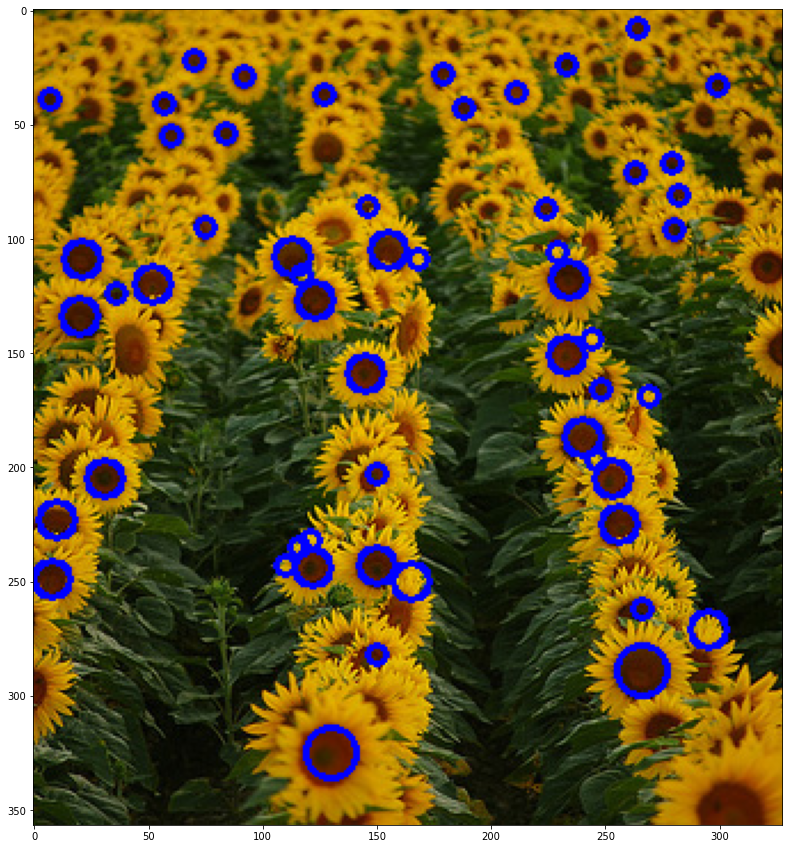

True

In [181]:
img_rgb = cv2.imread('Images/flowers.png')
img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2GRAY)
img_gray = img_gray / 255.0

min_sigma, max_sigma, num_sigma = 1 , 20 , 9
threshold = 0.025

blobs = detectBlob(img_gray , min_sigma, max_sigma, num_sigma , threshold , normalize=True)

for blob in blobs:
    y, x, r = blob
    # To remove the outliers or noise blobs
    if r < 3:
        continue
    y , x = int(y) , int(x)
#     r = int(sigma * np.sqrt(2))
    
    cv2.circle(img_rgb, (x, y), int(r), (0, 0, 255), 2)

# Display the image with marked blob centers
plt.figure(figsize=(24, 15))

plt.imshow(img_rgb)
plt.show()

img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
cv2.imwrite(f'./Report-Images/Task 2/Task 2.1/Our-Implementation.png' , img_rgb)

## Scikit-Learn Implementation

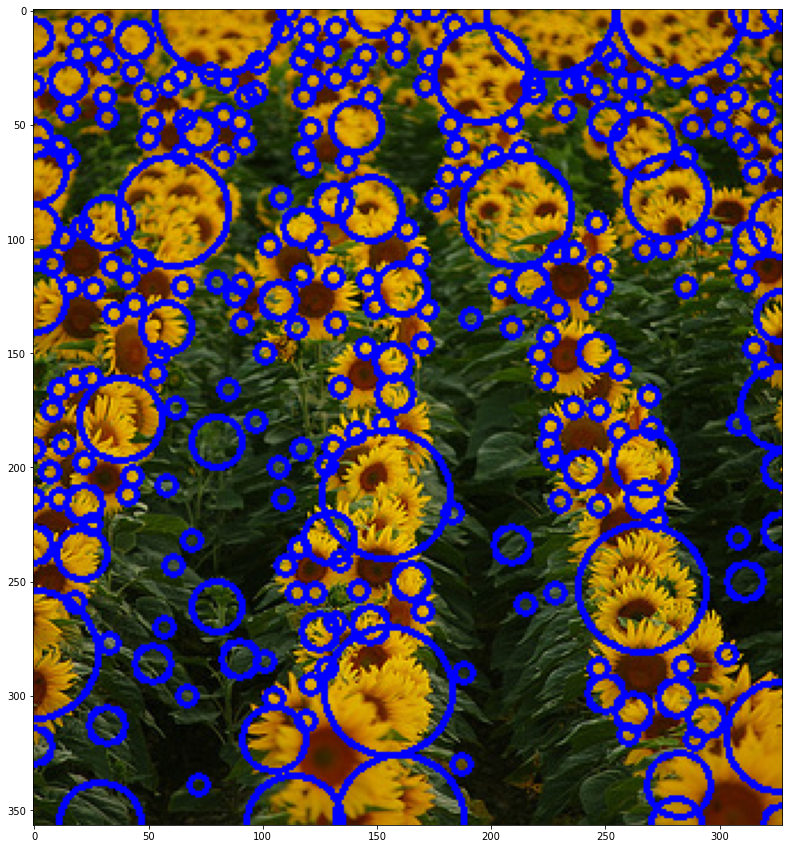

True

In [180]:
img_rgb = cv2.imread('Images/flowers.png')
img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2GRAY)
img_gray = img_gray / 255.0

min_sigma, max_sigma, num_sigma = 1 , 20 , 9
threshold = 0.025

blobs_log = blob_log(img_gray, min_sigma = min_sigma, max_sigma=max_sigma, num_sigma=num_sigma, threshold=threshold)

# Compute radii in the 3rd column.
blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)


blobs_list = [blobs_log]
colors = ['yellow']
titles = ['Laplacian of Gaussian']
sequence = zip(blobs_list, colors, titles)

# 0.1
img_rgb = cv2.imread('Images/flowers.png')
img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)

for blob in blobs_list[0]:
    y, x, r = blob
    # To remove the outliers or noisy blobs
    if r < 3:
        continue
    y , x = int(y) , int(x)
#     r = int(sigma * np.sqrt(2))
    
    cv2.circle(img_rgb, (x, y), int(r), (0, 0, 255), 2)

# Display the image with marked blob centers
plt.figure(figsize=(24, 15))

plt.imshow(img_rgb)
plt.show()

img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
cv2.imwrite(f'./Report-Images/Task 2/Task 2.1/Scikit-Implementation.png' , img_rgb)

## Task 2.2

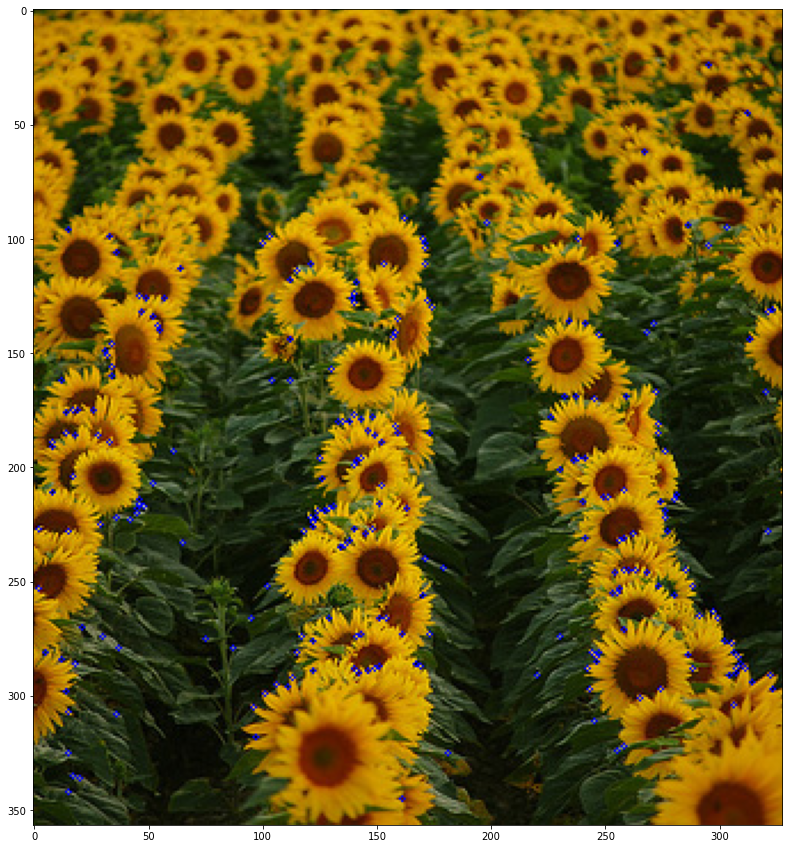

True

In [160]:
# Here, we only extracted the blob detection for non-normalized because for the normalized
# We already have extracted from the above code/task as we did it with the normalization.
img_rgb = cv2.imread('Images/flowers.png')
img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2GRAY)
img_gray = img_gray / 255.0

min_sigma, max_sigma, num_sigma = 1 , 20 , 9
threshold = 0.025

blobs = detectBlob(img_gray , min_sigma, max_sigma, num_sigma , threshold , normalize=False)

for blob in blobs:
    y, x, r = blob
    # To remove the outliers or noise blobs
    # But here, we comment this condition because the detected blobs are
    # already of very small radius so this will suppress all the detections
#     if r < 3:
#         continue
    y , x = int(y) , int(x)
#     r = int(sigma * np.sqrt(2))
    
    cv2.circle(img_rgb, (x, y), int(r), (0, 0, 255), 1)

# Display the image with marked blob centers
plt.figure(figsize=(24, 15))

plt.imshow(img_rgb)
plt.show()

img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
cv2.imwrite(f'./Report-Images/Task 2/Task 2.1/Our-Implementation-Non-Normalized.png' , img_rgb)

## Task 2.3

### Using Normalization

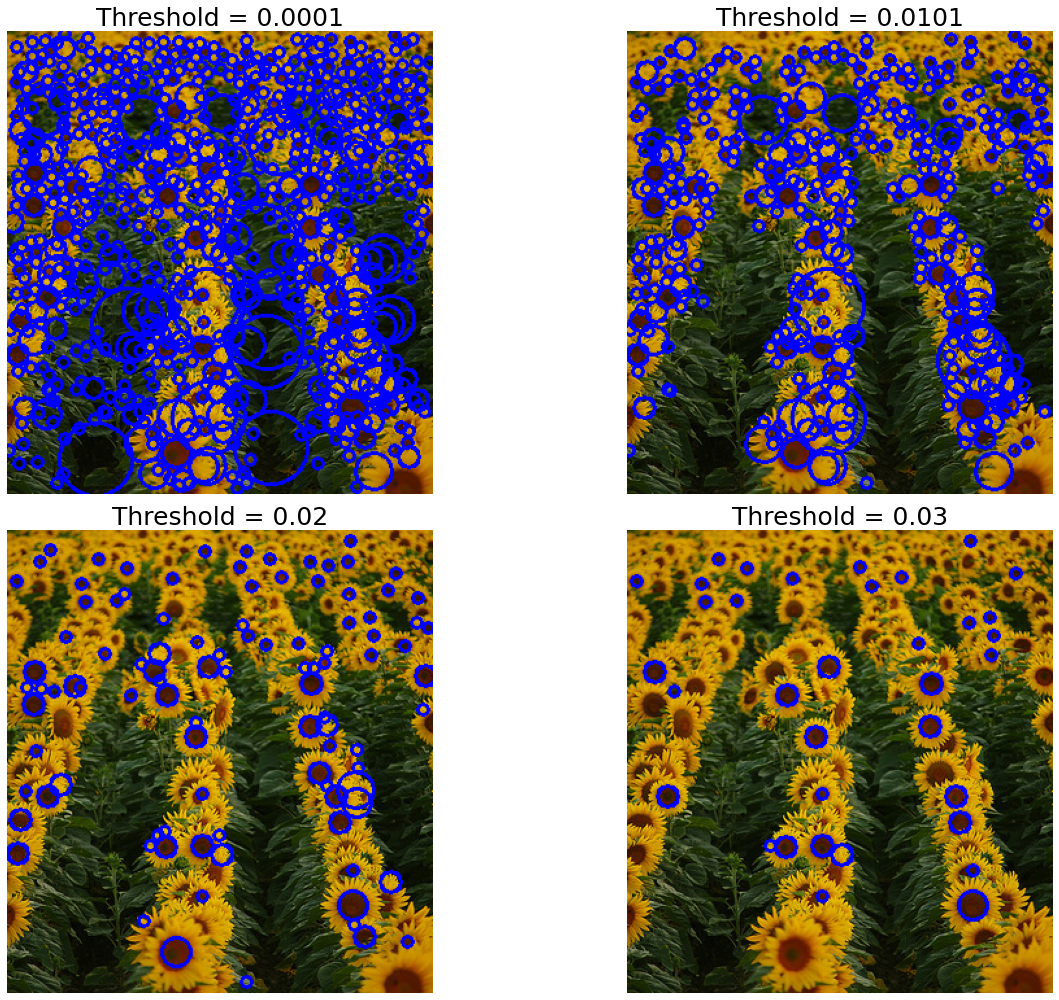

In [170]:
img_rgb = cv2.imread('Images/flowers.png')
img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2GRAY)
img_gray = img_gray / 255.0

min_sigma, max_sigma, num_sigma = 1 , 20 , 9

thresholds = np.linspace(0.0001, 0.03, 4)

thresholds = np.round(thresholds , 4)
# threshold = 0.025
num_cols = 2
fig, axes = plt.subplots(num_cols, num_cols, figsize=(20, 14))

for i , threshold in enumerate(thresholds):
    # Loading image again so that the blobs are plotted on fresh image
    img_rgb = cv2.imread('Images/flowers.png')
    img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
    
    row = i // num_cols
    col = i % num_cols
#     print(threshold)
    blobs = detectBlob(img_gray , min_sigma, max_sigma, num_sigma , threshold , normalize=True)

    for blob in blobs:
        y, x, r = blob
        y , x = int(y) , int(x)
        # To remove the outliers or noise blobs
        if r < 3:
            continue
    #     r = int(sigma * np.sqrt(2))

        cv2.circle(img_rgb, (x, y), int(r), (0, 0, 255), 2)

    # Display the image with marked blob centers
    axes[row, col].imshow(img_rgb)
    axes[row, col].set_title("Threshold = " + str(threshold) , fontsize = 25)
    axes[row, col].axis('off')
    
    img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'./Report-Images/Task 2/Task 2.3/Threshold-{threshold}.png' , img_rgb)


plt.tight_layout()

# Show the figure
plt.show()

### Using Without Normalization

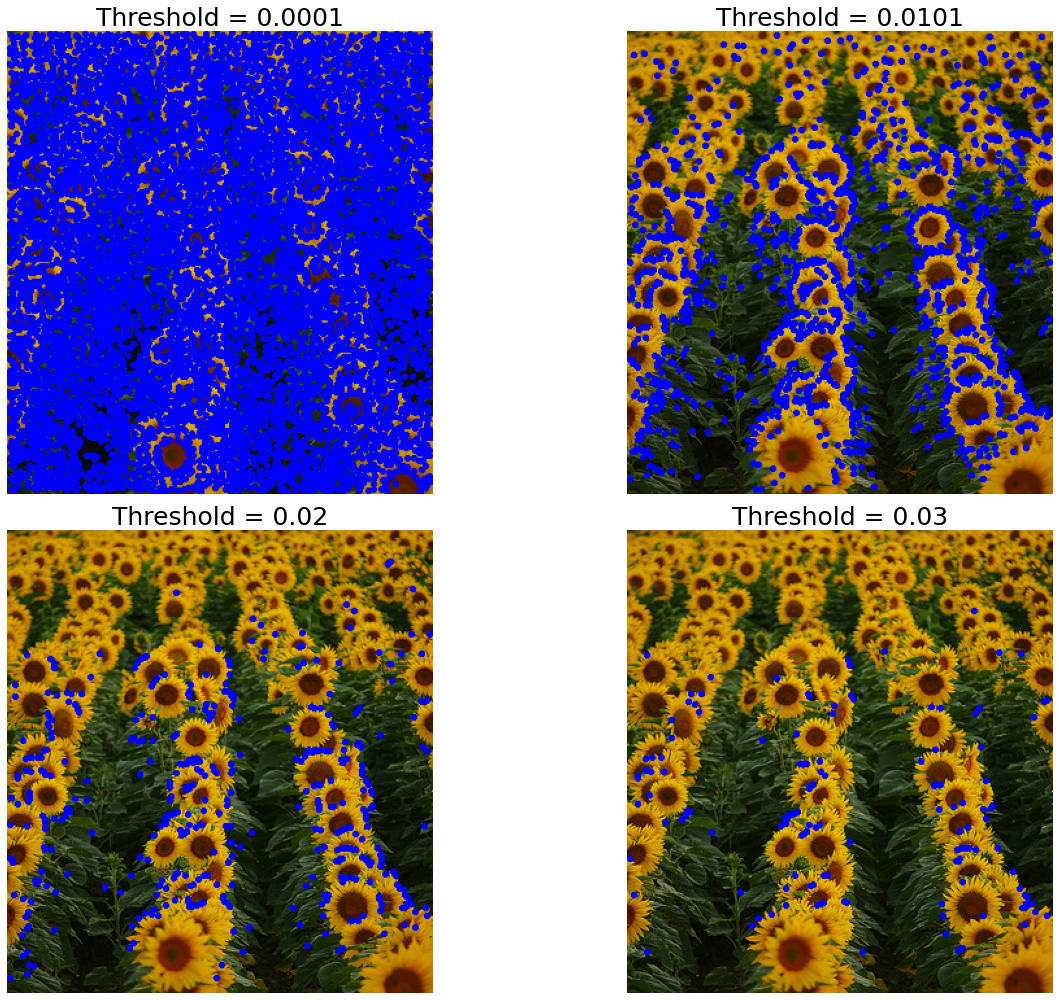

In [172]:
img_rgb = cv2.imread('Images/flowers.png')
img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2GRAY)
img_gray = img_gray / 255.0

min_sigma, max_sigma, num_sigma = 1 , 20 , 9

thresholds = np.linspace(0.0001, 0.03, 4)

thresholds = np.round(thresholds , 4)
# threshold = 0.025
num_cols = 2
fig, axes = plt.subplots(num_cols, num_cols, figsize=(20, 14))

for i , threshold in enumerate(thresholds):
    # Loading image again so that the blobs are plotted on fresh image
    img_rgb = cv2.imread('Images/flowers.png')
    img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
    
    row = i // num_cols
    col = i % num_cols
#     print(threshold)
    blobs = detectBlob(img_gray , min_sigma, max_sigma, num_sigma , threshold , normalize=False)

    for blob in blobs:
        y, x, r = blob
        y , x = int(y) , int(x)
        # To remove the outliers or noise blobs
        # But here, we comment this condition because the detected blobs are
        # already of very small radius so this will suppress all the detections
#         if r < 3:
#             continue
    #     r = int(sigma * np.sqrt(2))

        cv2.circle(img_rgb, (x, y), int(r), (0, 0, 255), 2)

    # Display the image with marked blob centers
    axes[row, col].imshow(img_rgb)
    axes[row, col].set_title("Threshold = " + str(threshold) , fontsize = 25)
    axes[row, col].axis('off')
    
    img_rgb = cv2.cvtColor(img_rgb , cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'./Report-Images/Task 2/Task 2.3/Threshold-{threshold}.png' , img_rgb)


plt.tight_layout()

# Show the figure
plt.show()